<a href="https://colab.research.google.com/github/katoyu/image-processing-100training/blob/master/%E7%94%BB%E5%83%8F%E5%87%A6%E7%90%86100%E6%9C%AC%E3%83%8E%E3%83%83%E3%82%AF41_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/Question_41_50/imori.jpg
!wget https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/Question_41_50/thorino.jpg
  
from google.colab.patches import cv2_imshow

--2019-04-27 14:47:51--  https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/Question_41_50/imori.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12638 (12K) [image/jpeg]
Saving to: ‘imori.jpg’

imori.jpg           100%[===================>]  12.34K  --.-KB/s    in 0s      

2019-04-27 14:47:51 (133 MB/s) - ‘imori.jpg’ saved [12638/12638]

--2019-04-27 14:47:52--  https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/Question_41_50/thorino.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27023 (26K) [image

#41 Cannyエッジ検出 (Step.1) エッジ強度

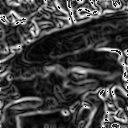

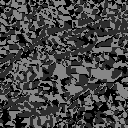

In [0]:
import cv2
import numpy as np

img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape
#1. グレースケール
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

#2. gaussianフィルタ 5x5 s=1.4
K_size = 5
sigma = 1.4

##zero padding
pad = K_size // 2
gau = np.zeros((H + pad*2, W + pad*2), dtype=np.float32)
gau = np.pad(gray, (pad, pad), 'edge')
tmp = gau.copy()

##Karnel
K = np.zeros((K_size, K_size), dtype=np.float32)
for x in range(-pad, -pad+K_size):
    for y in range(-pad, -pad+K_size):
           K[y+pad, x+pad] = np.exp( -(x**2 + y**2) / (2 * (sigma**2)))
            
K /= (sigma * np.sqrt(2 * np.pi))
K /= K.sum()

#3. x,y方向のSobelフィルタをかけ、画像の購買画像fx,fyを求め、勾配強度と勾配角度を次式で求める

for y in range(H):
    for x in range(W):
        gau[pad+y, pad+x] = np.sum(K * tmp[y:y+K_size, x:x+K_size])
        
##Sobel vertical
KSV = np.array(((-1., -2., -1.), (0., 0., 0.), (1., 2., 1.)), dtype=np.float32)
##Sobel horizontal
KSH = np.array(((-1., 0., 1.), (-2., 0., 2.), (-1., 0., 1.)), dtype=np.float32)

gau = gau[pad-1:H+pad+1, pad-1:W+pad+1]
fy = np.zeros_like(gau, dtype=np.float32)
fx  =np.zeros_like(gau, dtype=np.float32)
K_size = 3
pad = K_size//2

for y in range(H):
    for x in range(W):
        fy[pad+y, pad+x] = np.sum(KSV * gau[y:y+K_size, x:x+K_size])
        fx[pad+y, pad+x] = np.sum(KSH * gau[y:y+K_size, x:x+K_size])

fx = fx[pad:pad+H, pad:pad+W]
fy = fy[pad:pad+H, pad:pad+W]

# Non-maximum suppression

edge = np.sqrt(fx**2 + fy**2)

out1 = edge.astype(np.uint8)
cv2_imshow(out1)

fx[fx==0] = 1e-5
tan = np.arctan(fy/ fx)


#4. ヒステリシスによる閾値処理

angle = np.zeros_like(tan, dtype=np.uint8)
angle[np.where((tan > -0.4142) & (tan <= 0.4142))] = 0
angle[np.where((tan > 0.4142 ) & (tan  <2.4142))] = 45
angle[np.where((np.abs(tan)) >= 2.4142)] = 90
angle[np.where((tan > -2.4142) & (tan <= -0.4142))] = 135

out2 = angle.astype(np.uint8)

cv2_imshow(out2)

#42 Cannyエッジ検出 (Step.2) 細線化

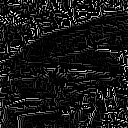

In [0]:
#41からの続き
for y in range(H):
    for x in range(W):
        if angle[y, x] == 0:
            dx1, dy1, dx2, dy2 = -1, 0, 1, 0
        elif angle[y, x] == 45:
            dx1, dy1, dx2, dy2 = -1, 1, 1, -1
        elif angle[y, x] == 90:
            dx1, dy1, dx2, dy2 = 0, -1, 0, 1
        elif angle[y, x] == 135:
            dx1, dy1, dx2, dy2 = -1, -1, 1, 1
        if x == 0:
            dx1 = max(dx1, 0)
            dx2 = max(dx2, 0)
        if x == W-1:
            dx1 = min(dx1, 0)
            dx2 = min(dx2, 0)
        if y == 0:
            dy1 = max(dy1, 0)
            dy2 = max(dy2, 0)
        if y == H-1:
            dy1 = min(dy1, 0)
            dy2 = min(dy2, 0)
        if max(max(edge[y, x], edge[y+dy1, x+dx1]), edge[y+dy2, x+dx2]) != edge[y, x]:
            edge[y, x] = 0

out = edge.astype(np.uint8)
cv2_imshow(out)

#43 Cannyエッジ検出 (Step.3) ヒステリシス閾処理


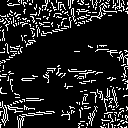

In [0]:
#41,42から続き

HT = 100
LT = 30

edge[edge >= HT] = 255
edge[edge <= LT] = 0

_edge = np.zeros((H+2, W+2), dtype=np.float32)
_edge[1:H+1, 1:W+1] = edge

# 8 -nearest neighbor
nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

for y in range(1, H+2):
    for x in range(1, W+2):

        if _edge[y, x] < LT or _edge[y, x] > HT:
            continue
        if np.max(_edge[y-1:y+2, x-1:x+2]*nn) >= HT:
            _edge[y, x] = 255
        else:
            _edge[y, x] = 0
edge = _edge[1:H+1, 1:W+1]

out = edge.astype(np.uint8)

cv2_imshow(out)


#44  Hough変換・直線検出 (Step.1) Hough変換

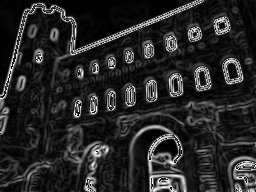

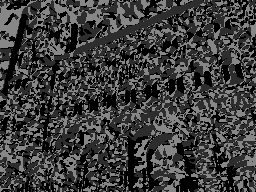

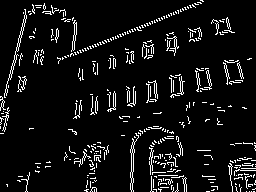

In [0]:
import cv2
import numpy as np

img = cv2.imread("thorino.jpg").astype(np.float32)
H, W, C = img.shape
#1. グレースケール
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

#2. gaussianフィルタ 5x5 s=1.4
K_size = 5
sigma = 1.4

##zero padding
pad = K_size // 2
gau = np.zeros((H + pad*2, W + pad*2), dtype=np.float32)
gau = np.pad(gray, (pad, pad), 'edge')
tmp = gau.copy()

##Karnel
K = np.zeros((K_size, K_size), dtype=np.float32)
for x in range(-pad, -pad+K_size):
    for y in range(-pad, -pad+K_size):
           K[y+pad, x+pad] = np.exp( -(x**2 + y**2) / (2 * (sigma**2)))
            
K /= (sigma * np.sqrt(2 * np.pi))
K /= K.sum()

#3. x,y方向のSobelフィルタをかけ、画像の購買画像fx,fyを求め、勾配強度と勾配角度を次式で求める

for y in range(H):
    for x in range(W):
        gau[pad+y, pad+x] = np.sum(K * tmp[y:y+K_size, x:x+K_size])
        
##Sobel vertical
KSV = np.array(((-1., -2., -1.), (0., 0., 0.), (1., 2., 1.)), dtype=np.float32)
##Sobel horizontal
KSH = np.array(((-1., 0., 1.), (-2., 0., 2.), (-1., 0., 1.)), dtype=np.float32)

gau = gau[pad-1:H+pad+1, pad-1:W+pad+1]
fy = np.zeros_like(gau, dtype=np.float32)
fx  =np.zeros_like(gau, dtype=np.float32)
K_size = 3
pad = K_size//2

for y in range(H):
    for x in range(W):
        fy[pad+y, pad+x] = np.sum(KSV * gau[y:y+K_size, x:x+K_size])
        fx[pad+y, pad+x] = np.sum(KSH * gau[y:y+K_size, x:x+K_size])

fx = fx[pad:pad+H, pad:pad+W]
fy = fy[pad:pad+H, pad:pad+W]

# Non-maximum suppression

edge = np.sqrt(fx**2 + fy**2)

out1 = edge.astype(np.uint8)
cv2_imshow(out1)

fx[fx==0] = 1e-5
tan = np.arctan(fy/ fx)


#4. ヒステリシスによる閾値処理

angle = np.zeros_like(tan, dtype=np.uint8)
angle[np.where((tan > -0.4142) & (tan <= 0.4142))] = 0
angle[np.where((tan > 0.4142 ) & (tan  <2.4142))] = 45
angle[np.where((np.abs(tan)) >= 2.4142)] = 90
angle[np.where((tan > -2.4142) & (tan <= -0.4142))] = 135

out2 = angle.astype(np.uint8)

cv2_imshow(out2)


#細線化
for y in range(H):
    for x in range(W):
        if angle[y, x] == 0:
            dx1, dy1, dx2, dy2 = -1, 0, 1, 0
        elif angle[y, x] == 45:
            dx1, dy1, dx2, dy2 = -1, 1, 1, -1
        elif angle[y, x] == 90:
            dx1, dy1, dx2, dy2 = 0, -1, 0, 1
        elif angle[y, x] == 135:
            dx1, dy1, dx2, dy2 = -1, -1, 1, 1
        if x == 0:
            dx1 = max(dx1, 0)
            dx2 = max(dx2, 0)
        if x == W-1:
            dx1 = min(dx1, 0)
            dx2 = min(dx2, 0)
        if y == 0:
            dy1 = max(dy1, 0)
            dy2 = max(dy2, 0)
        if y == H-1:
            dy1 = min(dy1, 0)
            dy2 = min(dy2, 0)
        if max(max(edge[y, x], edge[y+dy1, x+dx1]), edge[y+dy2, x+dx2]) != edge[y, x]:
            edge[y, x] = 0

#ヒステリシス閾処理
HT = 100
LT = 30

edge[edge >= HT] = 255
edge[edge <= LT] = 0

_edge = np.zeros((H+2, W+2), dtype=np.float32)
_edge[1:H+1, 1:W+1] = edge

# 8 -nearest neighbor
nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

for y in range(1, H+2):
    for x in range(1, W+2):

        if _edge[y, x] < LT or _edge[y, x] > HT:
            continue
        if np.max(_edge[y-1:y+2, x-1:x+2]*nn) >= HT:
            _edge[y, x] = 255
        else:
            _edge[y, x] = 0
edge = _edge[1:H+1, 1:W+1]

out = edge.astype(np.uint8)
cv2_imshow(out)

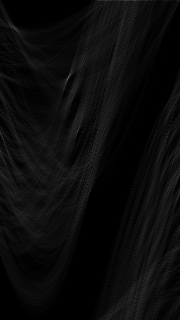

In [0]:
#Hough変換

#boting
drho = 1
dtheta = 1
rho_max = np.ceil(np.sqrt(H**2 + W**2)).astype(np.int)
hough = np.zeros((rho_max, 180), dtype=np.int)

ind = np.where(edge==255)

#hough transformation
for y, x in zip(ind[0], ind[1]):
    for theta in range(0, 180, dtheta):
        t = np.pi / 180 * theta
        rho = int(x * np.cos(t) + y * np.sin(t))
        hough[rho, theta] += 1

out = hough.astype(np.uint8)
cv2_imshow(out)

In [0]:
out.shape

(320, 180)

#45 Hough変換・直線検出 (Step.2) NMS


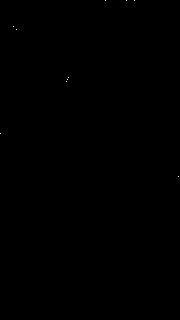

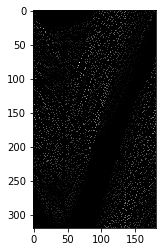

In [0]:
#44からの続き
import matplotlib.pyplot as plt

plt.imshow(hough, cmap='gray')

#non maximum suppression
for y in range(rho_max):
    for x in range(180):
        x1 = max(x-1, 0)
        x2 = min(x+2, 180)
        y1 = max(y-1, 0)
        y2 = min(y+2, rho_max)
        if np.max(hough[y1:y2, x1:x2]) == hough[y, x] and hough[y, x] != 0:
            pass
        else:
            hough[y, x] = 0
        
ind_x = np.argsort(hough.ravel())[::-1][:10]
ind_y = ind_x.copy()
thetas = ind_x % 180
rhos = ind_y // 180
#_hough = np.zeros_like(hough, dtype=np.int)
#_hough[rhos, thetas] = 255

out = _hough.astype(np.uint8)

cv2_imshow(out)       

#46 Hough変換・直線検出 (Step.3) Hough逆変換

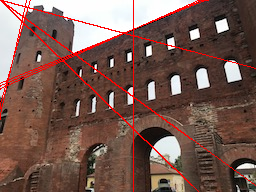

In [0]:
#44, 45からの続き
out = img.copy()

for theta, rho in zip(thetas, rhos):
    
    t = np.pi / 180. * theta
    for x in range(W):
        if np.sin(t) != 0:
            y = -(np.cos(t) / np.sin(t)) * x + rho / np.sin(t)
            y = int(y)
            if y >= H or y < 0:
                continue
            out[y, x] = [0, 0, 255]
            
    for y in range(H):
        if np.cos(t) != 0:
            x = -(np.sin(t) / np.cos(t)) * y + rho / np.cos(t)
            x = int(x)
            if x >= H or x < 0:
                continue
            out[y, x] = [0, 0, 255]

out = out.astype(np.uint8)
cv2_imshow(out)

#47 モルフォロジー処理(膨張)

threshold = 127


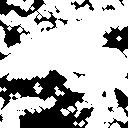

In [0]:
import cv2
import numpy as np

img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

#大津の二値化
out = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
out = out.astype(np.float32)

max_sigma = 0
max_t = 0
for _t in range(1, 255):
    v0 = out[np.where(out < _t)]
    m0 = np.mean(v0) if len(v0) > 0 else 0.
    w0  = len(v0) / (H * W)
    v1 = out[np.where(out >= _t)]
    m1 = np.mean(v1) if len(v1) > 0 else 0.
    w1 = len(v1) / (H * W)
    sigma = w0 * w1 * (m0 - m1) ** 2
    if sigma > max_sigma:
        max_sigma = sigma
        max_t = _t

##二値化
print("threshold = " +  str(max_t))
th = max_t
out[out < th] = 0
out[out >= th] = 255

#モルフォロジー処理
time = 2
MF = np.array(((0, 1, 0), 
                       (1, 0, 1),
                       (0, 1, 0)), dtype=np.int)

for i in range(time):
    tmp = np.pad(out, (1, 1), 'edge')
    for y in range(1, H+1):
        for x in range(1, W+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) >= 255:
                out[y-1, x-1] = 255
                
cv2_imshow(out)

#48 モルフォロジー処理(収縮)


threshold = 127


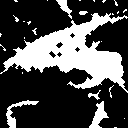

In [5]:
import cv2
import numpy as np

img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

#大津の二値化
out = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
out = out.astype(np.float32)

max_sigma = 0
max_t = 0
for _t in range(1, 255):
    v0 = out[np.where(out < _t)]
    m0 = np.mean(v0) if len(v0) > 0 else 0.
    w0  = len(v0) / (H * W)
    v1 = out[np.where(out >= _t)]
    m1 = np.mean(v1) if len(v1) > 0 else 0.
    w1 = len(v1) / (H * W)
    sigma = w0 * w1 * (m0 - m1) ** 2
    if sigma > max_sigma:
        max_sigma = sigma
        max_t = _t

##二値化
print("threshold = " +  str(max_t))
th = max_t
out[out < th] = 0
out[out >= th] = 255

#モルフォロジー処理
time = 2
MF = np.array(((0, 1, 0), 
                       (1, 0, 1),
                       (0, 1, 0)), dtype=np.int)

for i in range(time):
    tmp = np.pad(out, (1, 1), 'edge')
    for y in range(1, H+1):
        for x in range(1, W+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) < 255*4:
                out[y-1, x-1] = 0
                
cv2_imshow(out)

#49 オープニング処理

threshold = 127


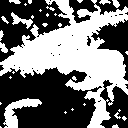

In [12]:
import cv2
import numpy as np

img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

#大津の二値化
out = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
out = out.astype(np.float32)

max_sigma = 0
max_t = 0
for _t in range(1, 255):
    v0 = out[np.where(out < _t)]
    m0 = np.mean(v0) if len(v0) > 0 else 0.
    w0  = len(v0) / (H * W)
    v1 = out[np.where(out >= _t)]
    m1 = np.mean(v1) if len(v1) > 0 else 0.
    w1 = len(v1) / (H * W)
    sigma = w0 * w1 * (m0 - m1) ** 2
    if sigma > max_sigma:
        max_sigma = sigma
        max_t = _t

##二値化
print("threshold = " +  str(max_t))
th = max_t
out[out < th] = 0
out[out >= th] = 255

#モルフォロジー処理
dil_time = 1
ero_time = 1
MF = np.array(((0, 1, 0), 
                       (1, 0, 1),
                       (0, 1, 0)), dtype=np.int)

for i in range(dil_time):
    #収縮
    tmp = np.pad(out, (1, 1), 'edge')
    for y in range(1, H+1):
        for x in range(1, W+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) < 255*4:
                out[y-1, x-1] = 0
                
for i in range(ero_time):
    #膨張
    tmp = np.pad(out, (1, 1), 'edge')
    for y in range(1, H+1):
        for x in range(1, W+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) >= 255:
                out[y-1, x-1] = 255

cv2_imshow(out)

#50 クロージング処理

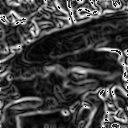

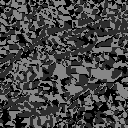

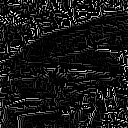

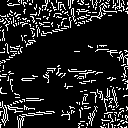

threshold = 127


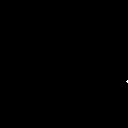

In [14]:
import cv2
import numpy as np

img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

import cv2
import numpy as np

img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape
#1. グレースケール
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

#2. gaussianフィルタ 5x5 s=1.4
K_size = 5
sigma = 1.4

##zero padding
pad = K_size // 2
gau = np.zeros((H + pad*2, W + pad*2), dtype=np.float32)
gau = np.pad(gray, (pad, pad), 'edge')
tmp = gau.copy()

##Karnel
K = np.zeros((K_size, K_size), dtype=np.float32)
for x in range(-pad, -pad+K_size):
    for y in range(-pad, -pad+K_size):
           K[y+pad, x+pad] = np.exp( -(x**2 + y**2) / (2 * (sigma**2)))
            
K /= (sigma * np.sqrt(2 * np.pi))
K /= K.sum()

#3. x,y方向のSobelフィルタをかけ、画像の購買画像fx,fyを求め、勾配強度と勾配角度を次式で求める

for y in range(H):
    for x in range(W):
        gau[pad+y, pad+x] = np.sum(K * tmp[y:y+K_size, x:x+K_size])
        
##Sobel vertical
KSV = np.array(((-1., -2., -1.), (0., 0., 0.), (1., 2., 1.)), dtype=np.float32)
##Sobel horizontal
KSH = np.array(((-1., 0., 1.), (-2., 0., 2.), (-1., 0., 1.)), dtype=np.float32)

gau = gau[pad-1:H+pad+1, pad-1:W+pad+1]
fy = np.zeros_like(gau, dtype=np.float32)
fx  =np.zeros_like(gau, dtype=np.float32)
K_size = 3
pad = K_size//2

for y in range(H):
    for x in range(W):
        fy[pad+y, pad+x] = np.sum(KSV * gau[y:y+K_size, x:x+K_size])
        fx[pad+y, pad+x] = np.sum(KSH * gau[y:y+K_size, x:x+K_size])

fx = fx[pad:pad+H, pad:pad+W]
fy = fy[pad:pad+H, pad:pad+W]

# Non-maximum suppression

edge = np.sqrt(fx**2 + fy**2)

out1 = edge.astype(np.uint8)
cv2_imshow(out1)

fx[fx==0] = 1e-5
tan = np.arctan(fy/ fx)


#4. ヒステリシスによる閾値処理

angle = np.zeros_like(tan, dtype=np.uint8)
angle[np.where((tan > -0.4142) & (tan <= 0.4142))] = 0
angle[np.where((tan > 0.4142 ) & (tan  <2.4142))] = 45
angle[np.where((np.abs(tan)) >= 2.4142)] = 90
angle[np.where((tan > -2.4142) & (tan <= -0.4142))] = 135

out2 = angle.astype(np.uint8)

cv2_imshow(out2)

#41からの続き
for y in range(H):
    for x in range(W):
        if angle[y, x] == 0:
            dx1, dy1, dx2, dy2 = -1, 0, 1, 0
        elif angle[y, x] == 45:
            dx1, dy1, dx2, dy2 = -1, 1, 1, -1
        elif angle[y, x] == 90:
            dx1, dy1, dx2, dy2 = 0, -1, 0, 1
        elif angle[y, x] == 135:
            dx1, dy1, dx2, dy2 = -1, -1, 1, 1
        if x == 0:
            dx1 = max(dx1, 0)
            dx2 = max(dx2, 0)
        if x == W-1:
            dx1 = min(dx1, 0)
            dx2 = min(dx2, 0)
        if y == 0:
            dy1 = max(dy1, 0)
            dy2 = max(dy2, 0)
        if y == H-1:
            dy1 = min(dy1, 0)
            dy2 = min(dy2, 0)
        if max(max(edge[y, x], edge[y+dy1, x+dx1]), edge[y+dy2, x+dx2]) != edge[y, x]:
            edge[y, x] = 0

out = edge.astype(np.uint8)
cv2_imshow(out)

#41,42から続き

HT = 100
LT = 30

edge[edge >= HT] = 255
edge[edge <= LT] = 0

_edge = np.zeros((H+2, W+2), dtype=np.float32)
_edge[1:H+1, 1:W+1] = edge

# 8 -nearest neighbor
nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

for y in range(1, H+2):
    for x in range(1, W+2):

        if _edge[y, x] < LT or _edge[y, x] > HT:
            continue
        if np.max(_edge[y-1:y+2, x-1:x+2]*nn) >= HT:
            _edge[y, x] = 255
        else:
            _edge[y, x] = 0
edge = _edge[1:H+1, 1:W+1]

out = edge.astype(np.uint8)

cv2_imshow(out)


##二値化
print("threshold = " +  str(max_t))
th = max_t
out[out < th] = 0
out[out >= th] = 255

#モルフォロジー処理
dil_time = 1
ero_time = 1
MF = np.array(((0, 1, 0), 
                       (1, 0, 1),
                       (0, 1, 0)), dtype=np.int)

for i in range(dil_time):
    #収縮
    tmp = np.pad(out, (1, 1), 'edge')
    for y in range(1, H+1):
        for x in range(1, W+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) < 255*4:
                out[y-1, x-1] = 0
                
for i in range(ero_time):
    #膨張
    tmp = np.pad(out, (1, 1), 'edge')
    for y in range(1, H+1):
        for x in range(1, W+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) >= 255:
                out[y-1, x-1] = 255

cv2_imshow(out)

#最後違うみたい